##　7.7 稠密连接网络
稠密连接网络（DenseNet） (Huang et al., 2017)在某种程度上是ResNet的逻辑扩展。

### 7.7.1 从ResNet到DenseNet
ResNet将函数展开为$$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x})$$
ResNet将$f$分解为两部分：一个简单的线性项和一个复杂的非线性项。 那么再向前拓展一步，如果我们想将$f$拓展成超过两部分的信息呢？ 一种方案便是DenseNet。  
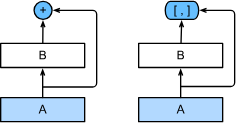  
ResNet和DenseNet的关键区别在于，DenseNet输出是连接（用图中的[,]表示）而不是如ResNet的简单相加。  
$$
\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].
$$
最后，将这些展开式结合到多层感知机中，再次减少特征的数量。 实现起来非常简单：我们不需要添加术语，而是将它们连接起来。 DenseNet这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。  
稠密网络主要由2部分构成：**稠密块**（dense block）和**过渡层**（transition layer）。 前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

### 7.7.2. 稠密块体

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

c:\Users\yy200\miniconda3\envs\d2l\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels
            ))
        self.net = nn.Sequential(*layer)
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X

In [5]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

### 7.7.3 过渡层
由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。 而过渡层可以用来控制模型复杂度。 它通过$1 \times 1$
卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [ ]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [8]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### 7.7.4. DenseNet模型

In [ ]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [ ]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

### 7.7.5 训练模型

loss 0.142, train acc 0.947, test acc 0.887
2324.0 examples/sec on cuda:0


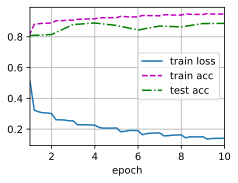

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

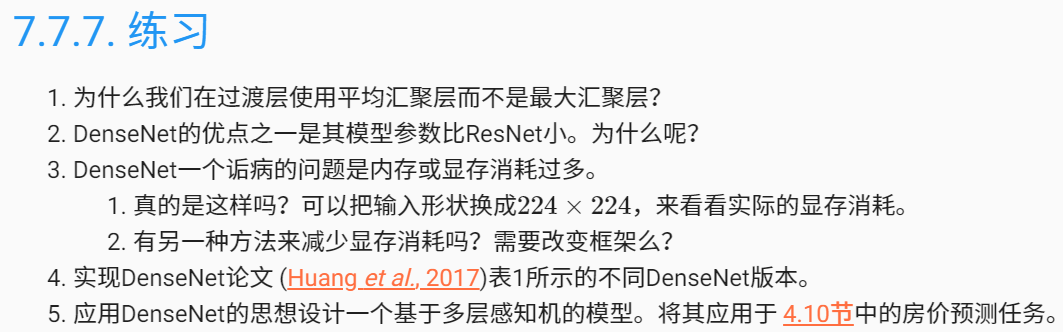

### 解决图像中的问题

#### 1. 为什么我们在过渡层使用平均汇聚层而不是最大汇聚层？
平均汇聚层能够更好地保留特征的整体信息，而最大汇聚层可能会丢失一些细节信息。DenseNet的设计目标是通过稠密连接充分利用特征，因此平均汇聚层更适合。

#### 2. DenseNet的优点之一是其模型参数比ResNet小。为什么呢？
DenseNet通过稠密连接复用特征，避免了重复计算，从而减少了参数数量。而ResNet每一层都需要重新计算特征，导致参数较多。

#### 3. DenseNet一个诟病的问题是内存或显存消耗过多。
1. **真的有这样吗？可以把输入形状换成 $224 \times 224$，来看看实际的显存消耗。**  
    是的，DenseNet的显存消耗较高，因为每一层的输出都需要保留以供后续层使用。可以通过实验观察显存占用情况。

2. **有另一种方法来减少显存消耗吗？需要改变框架么？**  
    可以使用梯度检查点（Gradient Checkpointing）技术来减少显存消耗。这种方法不需要改变框架，只需在训练时重新计算部分中间结果。

#### 4. 实现DenseNet论文（Huang et al., 2017）表1所示的不同DenseNet版本。
可以通过调整DenseNet的超参数（如稠密块的数量、每个稠密块的卷积层数、增长率等）来实现表1中的不同版本。

#### 5. 应用DenseNet的思想设计一个基于多层感知机的模型。将其应用于4.10节中的房价预测任务。
可以将DenseNet的稠密连接思想应用于多层感知机（MLP），即每一层的输出与之前所有层的输出连接起来作为下一层的输入。然后将其用于房价预测任务。
